In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob 

sys.path.append("/glade/u/home/jhayron/WR_Predictability/3_MLModels/")
from model_builders_v2 import *

2023-10-17 12:36:52.274221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

In [3]:
wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230824.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [4]:
path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/'

In [5]:
files_weekly_anoms = np.sort(glob.glob(f'{path_weekly_anoms}/*.nc'))

In [6]:
ifile = 4

In [7]:
file_temp = files_weekly_anoms[ifile]
dataset = xr.open_dataset(file_temp)
var_name = list(dataset.data_vars.keys())[0]
print(file_temp,var_name)
dataset = dataset.load()

name_var = file_temp.split('/')[-1][:-3]

### Find and drop useless (always zero, pixels)
flattened_da = dataset.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
nan_mask = flattened_da.isnull().all(dim='time')
# nan_mask = flattened_da.isnull().any(dim='time')
where_nonan = np.where(nan_mask==False)[0]
flattened_nonan = flattened_da[:,where_nonan]
flattened_nonan = flattened_nonan.fillna(0)

# create pca object
pca_obj = PCA(12, whiten=True)##

# fit pca with era5
pca_obj = pca_obj.fit(flattened_nonan)

# transform era5 data with pca
transformed_da = pca_obj.transform(flattened_nonan)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')
transformed_da = pd.DataFrame(transformed_da,index = dataset.time)

/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/OHC200_SODA.nc ocean_heat_content_anomalies
Variance explained: [18.85663106  7.95921654  3.5038239   2.8873108   2.64145276  2.16534322
  1.92030703  1.82424266  1.65325496  1.42759645  1.17216084  1.10594565]
Cumulative sum of variance explained for EOF1 and EOF2: [18.85663106 26.8158476  30.3196715  33.2069823  35.84843505 38.01377827
 39.93408531 41.75832796 43.41158293 44.83917938 46.01134021 47.11728587]


In [8]:
# For each PC, plot map and plot anomalies in WR histogram for each week

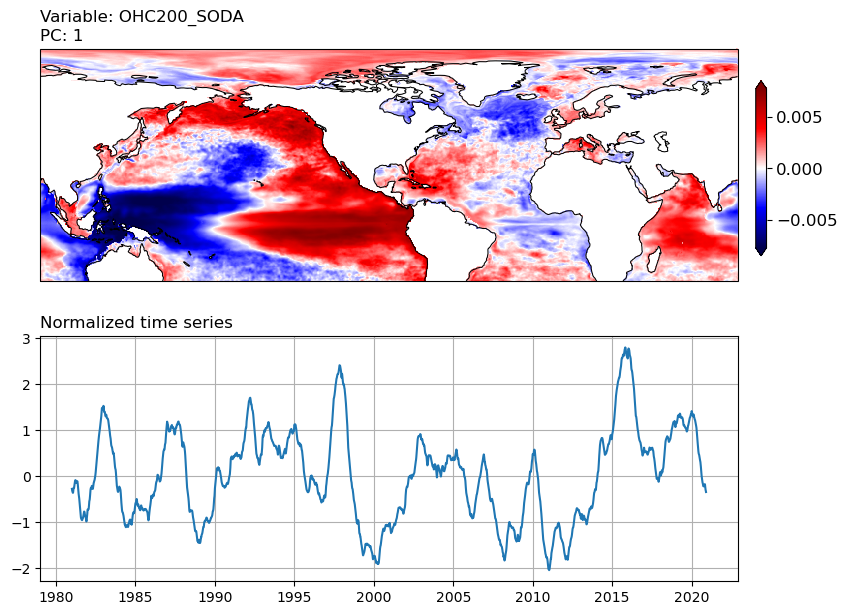

In [9]:
ipc = 1

pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
# flattened_nonan.isel(time=0).values = pca_obj.components_[0]
pc_flattened_nonan.values = pca_obj.components_[ipc]
pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
array_temp = copy.deepcopy(pc_flattened.values)
array_temp[where_nonan] = pc_flattened_nonan.values
pc_flattened.values  = array_temp
unstacked_pc = pc_flattened.unstack('flat')

##########PLOT MAP #####################
symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=-90+360))

# print(vmax,vmin)
cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
    unstacked_pc.values,cmap='seismic',
    transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)

plt.xlim()

plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')

cbar_ax = fig.add_axes([0.92, 0.575,0.012,0.25])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=12)
# cbar.set_label(trend.units, fontsize=14)
ax2 = fig.add_subplot(212)
ax2.plot(transformed_da[ipc])
ax2.grid()
plt.title(f'Normalized time series',loc='left')
plt.show()

In [10]:
df_wr_temp = df_shifts['week0'].dropna()
mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

In [11]:
normalized_pc = transformed_da[ipc]/np.nanmax(abs(transformed_da[ipc]))

In [12]:
bins = np.percentile(normalized_pc,[0,20,40,60,80,100])
mid_bins = np.array([10,30,50,70,90]) ##

In [13]:
week = 1
df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

In [14]:
prob2d = np.zeros([5,len(mid_bins)])
hist_pc_ranges = []##
p_values = []
for ibin in range(len(bins)-1):
    # print(bin_center)
    df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
    # print(len(df_temp))
    hist_pc_ranges.append(len(df_temp))
    hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
    hist_temp = hist_temp/np.sum(hist_temp)
    diff_temp = hist_temp-mean_hist_wrs
    prob2d[:,ibin] = diff_temp
    
    freq_table_A = df_wr_temp.value_counts().sort_index()##
    freq_table_B = df_temp.value_counts().sort_index()##
    observed = pd.concat([freq_table_A, freq_table_B], axis=1).fillna(0).values##
    chi2, p, _, _ = chi2_contingency(observed)##
    
    p_values.append(p)##
    # aaa

In [15]:
names_wr = ['WR1: IH','WR2: PH', 'WR3: IL', 'WR4: PL', 'WR5: Clima']

In [16]:
p_values = np.array(p_values)##
avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)

/glade/scratch/jhayron/ipykernel_59055/3392367967.py:14: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)


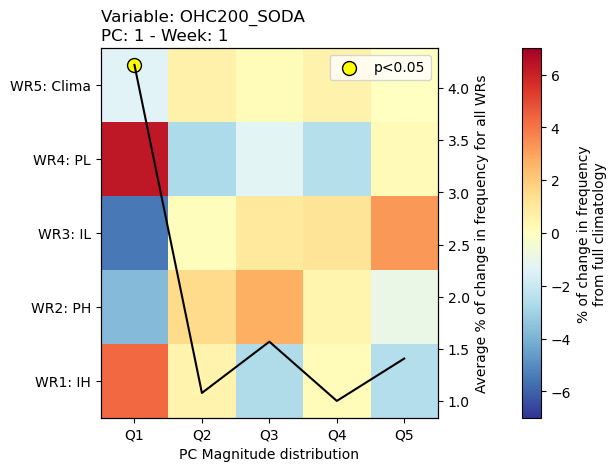

In [17]:
fig, ax1 = plt.subplots()
cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-7,vmax=7,cmap='RdYlBu_r')

ax1.set_xticks(mid_bins,['Q1','Q2','Q3','Q4','Q5'])
ax1.set_xlabel('PC Magnitude distribution')

ax2 = ax1.twinx()
ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
ax2.scatter(mid_bins[p_values<=0.05],[avg_hist_change_for_week[p_values<=0.05]*100],
            color='yellow',edgecolors='k',s=100,label='p<0.05')##
ax2.set_ylabel('Average % of change in frequency for all WRs')
ax2.legend()

cbar = plt.colorbar(cm,pad=0.17)
cbar.set_label('% of change in frequency\nfrom full climatology')

plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
plt.show()

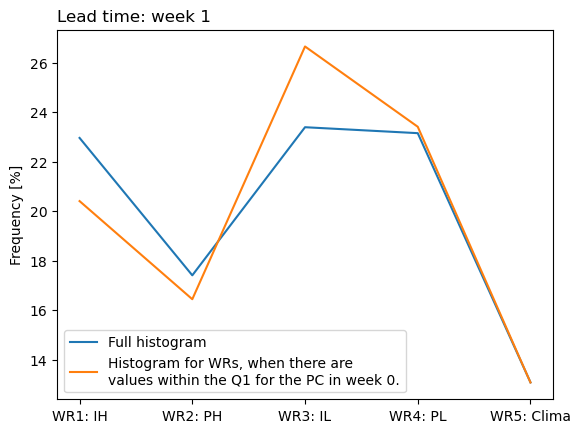

In [18]:
plt.close('all')
plt.plot(names_wr,mean_hist_wrs*100,label = 'Full histogram')
plt.plot(names_wr,hist_temp*100,label = 'Histogram for WRs, when there are \nvalues within the Q1 for the PC in week 0.')
plt.ylabel('Frequency [%]')
plt.legend()
plt.title(f'Lead time: week {week}',loc='left')
# plt.xticks()
plt.show()

# Iterate through weeks

In [19]:
names_wr = ['WR1: IH','WR2: PH', 'WR3: IL', 'WR4: PL', 'WR5: Clima']

In [20]:
path_figures = f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/{name_var}/pc{ipc}/'

In [21]:
try: os.mkdir(path_figures)
except: pass

try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/{name_var}/')
except: pass

In [22]:
avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])
p_val_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])

for week in [1,2,3,4,5,6,7,8]:
    df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

    prob2d = np.zeros([5,len(mid_bins)])
    p_values = []##
    for ibin in range(len(bins)-1):
        # print(bin_center)
        df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
        hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
        hist_temp = hist_temp/np.sum(hist_temp)
        diff_temp = hist_temp - mean_hist_wrs
        prob2d[:,ibin] = diff_temp
        
        freq_table_A = df_wr_temp.value_counts().sort_index()##
        freq_table_B = df_temp.value_counts().sort_index()##
        observed = pd.concat([freq_table_A, freq_table_B], axis=1).fillna(0).values##
        chi2, p, _, _ = chi2_contingency(observed)##

        p_values.append(p)##
        
    p_values = np.array(p_values)##
    avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
    p_val_bins_weeks[:,week-1] = p_values
    avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week
    
    ### Plot for week ###
    fig, ax1 = plt.subplots()
    cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-7,vmax=7,cmap='RdYlBu_r')

    ax1.set_xticks(mid_bins,['Q1','Q2','Q3','Q4','Q5'])
    ax1.set_xlabel('PC Magnitude distribution')

    ax2 = ax1.twinx()
    ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
    ax2.scatter(mid_bins[p_values<=0.05],[avg_hist_change_for_week[p_values<=0.05]*100],
                color='yellow',edgecolors='k',s=100,label='p<0.05')##
    ax2.set_ylabel('Average % of change in frequency for all WRs')
    ax2.legend()

    cbar = plt.colorbar(cm,pad=0.17)
    cbar.set_label('% of change in frequency\nfrom full climatology')

    plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
    plt.savefig(f'{path_figures}2dDiff_{name_var}_PC{ipc}_week{week}.png')
    plt.close('all')

/glade/scratch/jhayron/ipykernel_59055/29975367.py:43: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_59055/29975367.py:43: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_59055/29975367.py:43: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm

Text(0.0, 1.0, 'Variable: OHC200_SODA\nPC: 1')

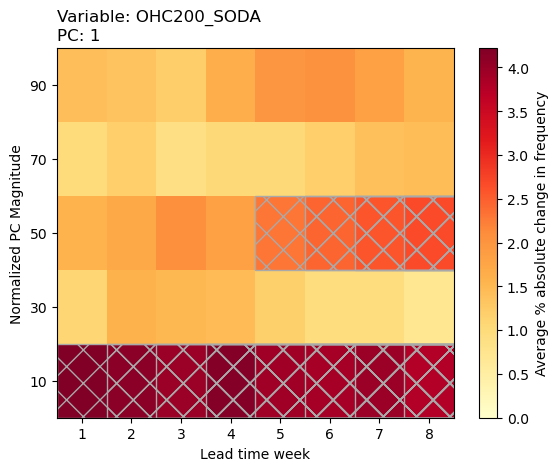

In [24]:
fig, ax1 = plt.subplots()
lead_time_week = np.arange(1,9)
cm = ax1.pcolormesh(lead_time_week,mid_bins,avg_change_bins_weeks*100,
                    vmin=0,cmap='YlOrRd')

ax1.set_yticks(mid_bins)
ax1.set_xlabel('Lead time week')
ax1.set_ylabel('Normalized PC Magnitude')

# Overlay hatch patterns where p-values are below the threshold
# p_values_significant = p_val_bins_weeks > 0.05
# ax1.pcolormesh([1,2,3,4,5,6,7,8],mid_bins,p_values_significant,
#            cmap='gray', alpha=0.1)

# Plot the meshgrid
for i in range(len(mid_bins)):
    for j in range(len(lead_time_week)):
        value = p_val_bins_weeks[i, j]
        if value < 0.05:
            hatch_pattern = 'x'
            ax1.add_patch(plt.Rectangle((lead_time_week[j]-0.5, mid_bins[i] - 10), 20, 20, 
                                        fill=False, hatch=hatch_pattern, color='darkgray'))

cbar = plt.colorbar(cm)
cbar.set_label('Average % absolute change in frequency')

plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')
# plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/abs_chng_freq_pc{ipc}.png',
#             bbox_inches='tight')
# plt.close('all')

# Iterate through all variables

In [46]:
for ifile in range(len(files_weekly_anoms)):
    file_temp = files_weekly_anoms[ifile]
    dataset = xr.open_dataset(file_temp)
    var_name = list(dataset.data_vars.keys())[0]
    print(file_temp,var_name)
    dataset = dataset.load()

    name_var = file_temp.split('/')[-1][:-3]
    if name_var == 'SST_OISSTv2':
        continue
    ### Find and drop useless (always zero, pixels)
    flattened_da = dataset.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
    # nan_mask = flattened_da.isnull().all(dim='time')
    nan_mask = flattened_da.isnull().any(dim='time')
    where_nonan = np.where(nan_mask==False)[0]
    flattened_nonan = flattened_da[:,where_nonan]
    flattened_nonan = flattened_nonan.fillna(0)
    # aaaa
    # create pca object
    pca_obj = PCA(12, whiten=True)

    # fit pca with era5
    pca_obj = pca_obj.fit(flattened_nonan)

    # transform era5 data with pca
    transformed_da = pca_obj.transform(flattened_nonan)

    print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
    print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')
    transformed_da = pd.DataFrame(transformed_da,index = dataset.time)


    df_wr_temp = df_shifts['week0'].dropna()
    mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
    mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

    try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/{name_var}/')
    except: pass

    transformed_da.to_csv(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/{name_var}/PC_{name_var}.csv')

    for ipc in range(12):
        # print(f'PC: {ipc}**********************')
        ##########Unstack PC #####################
        pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
        # flattened_nonan.isel(time=0).values = pca_obj.components_[0]
        pc_flattened_nonan.values = pca_obj.components_[ipc]
        pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
        array_temp = copy.deepcopy(pc_flattened.values)
        array_temp[where_nonan] = pc_flattened_nonan.values
        pc_flattened.values  = array_temp
        unstacked_pc = pc_flattened.unstack('flat')

        ##########PLOT MAP #####################
        symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=-90+360))

        # print(vmax,vmin)
        cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
            unstacked_pc.values,cmap='seismic',
            transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
        ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
        ax.margins(x=0, y=0)

        plt.xlim()

        plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')

        cbar_ax = fig.add_axes([0.92, 0.575,0.012,0.25])
        cbar = fig.colorbar(cs,cax=cbar_ax,orientation='vertical', extend='both')
        cbar.ax.tick_params(labelsize=14)
        # cbar.set_label(trend.units, fontsize=14)
        ax2 = fig.add_subplot(212)
        ax2.plot(transformed_da[ipc])
        ax2.set_ylim(np.percentile(transformed_da[ipc],1),np.percentile(transformed_da[ipc],99))
        ax2.grid()
        plt.title(f'Normalized time series',loc='left')
        
        plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/{name_var}/map_pc{ipc}.png',
                bbox_inches='tight')
        plt.close('all')
        ##########Normalize PC #####################
        normalized_pc = transformed_da[ipc]/np.nanmax(abs(transformed_da[ipc]))
        # plt.plot(normalized_pc)
        # plt.show()
        # plt.close('all')
        ##########Get conditional histogram for each bin within PC #####################
        bins = np.percentile(normalized_pc,[0,20,40,60,80,100])
        mid_bins = np.array([10,30,50,70,90])

        avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])
        p_val_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])
        
        path_figures = f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/{name_var}/pc{ipc}/'
        try: os.mkdir(path_figures)
        except: pass
        
        for week in [1,2,3,4,5,6,7,8]:
            df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()
            p_values = []
            for ibin in range(len(bins)-1):
                # print(bin_center)
                df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
                hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
                hist_temp = hist_temp/np.sum(hist_temp)
                diff_temp = hist_temp - mean_hist_wrs
                prob2d[:,ibin] = diff_temp
                
                freq_table_A = df_wr_temp.value_counts().sort_index()##
                freq_table_B = df_temp.value_counts().sort_index()##
                observed = pd.concat([freq_table_A, freq_table_B], axis=1).fillna(0).values##
                chi2, p, _, _ = chi2_contingency(observed)##

                p_values.append(p)##
            p_values = np.array(p_values)##

            avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
            p_val_bins_weeks[:,week-1] = p_values
            avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week
            
            ### Plot for week ###
            fig, ax1 = plt.subplots()
            cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-8,vmax=8,cmap='bwr')

            ax1.set_xticks(mid_bins,['Q1','Q2','Q3','Q4','Q5'])
            ax1.set_xlabel('PC Magnitude distribution')

            ax2 = ax1.twinx()
            ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
            ax2.scatter(mid_bins[p_values<=0.05],[avg_hist_change_for_week[p_values<=0.05]*100],
                        color='yellow',edgecolors='k',s=100,label='p<0.05')##
            ax2.set_ylabel('Average % of change in frequency for all WRs')
            ax2.legend()

            cbar = plt.colorbar(cm,pad=0.17,ax=ax1)
            cbar.set_label('% of change in frequency\nfrom full climatology')

            plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
            plt.savefig(f'{path_figures}2dDiff_{name_var}_PC{ipc}_week{week}.png')
            plt.close('all')

        ##########Plot average change in frequency for each week and bin #####################
        fig, ax1 = plt.subplots()
        lead_time_week = np.arange(1,9)
        cm = ax1.pcolormesh(lead_time_week,mid_bins,avg_change_bins_weeks*100,
                            vmin=0,vmax=4,cmap='YlOrRd')

        ax1.set_yticks(mid_bins)
        ax1.set_xlabel('Lead time week')
        ax1.set_ylabel('Normalized PC Magnitude')

        # Plot the meshgrid
        for i in range(len(mid_bins)):
            for j in range(len(lead_time_week)):
                value = p_val_bins_weeks[i, j]
                if value <= 0.05:
                    hatch_pattern = 'x'
                    ax1.add_patch(plt.Rectangle((lead_time_week[j]-0.5, mid_bins[i] - 10), 1, 20, 
                                                fill=False, hatch=hatch_pattern, color='darkgray'))

        cbar = plt.colorbar(cm,ax=ax1)
        cbar.set_label('Average % absolute change in frequency')

        plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')
        plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/{name_var}/abs_chng_freq_pc{ipc}.png',
                    bbox_inches='tight')
        plt.close('all')

/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/IC_SODA.nc cn_total_anomalies
Variance explained: [26.259812   14.78141695 14.44907786 10.7516763   8.40034324  7.36922848
  3.51379622  3.00807227  1.72517499  1.50750389  1.40423835  1.05774913]
Cumulative sum of variance explained for EOF1 and EOF2: [26.259812   41.04122896 55.49030682 66.24198311 74.64232635 82.01155484
 85.52535106 88.53342333 90.25859832 91.76610221 93.17034056 94.22808969]
/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/IT_SODA.nc hi_anomalies
Variance explained: [29.14353837 26.23820994 20.06255798  5.9073012   3.15595641  2.81946254
  2.44630171  1.51045593  1.2993133   0.66707771  0.61913121  0.5455068 ]
Cumulative sum of variance explained for EOF1 and EOF2: [29.14353837 55.38174831 75.44430629 81.35160749 84.50756389 87.32702644
 89.77332815 91.28378407 92.58309737 93.25017508 93.86930629 94.41481309]
/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTre